# Capstone: Image Classification
## Classifying CT Scans of Lung Cancer 

In [190]:
# Installations needed
# !pip install pydicom ## allows for reading of dicom data
# !pip install opencv-python ## image processing library
# !pip install pyyaml h5py ## checkpoint models

In [265]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow & Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Sklearn Imports
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [192]:
print(tf.version.VERSION)

2.9.1


## Importing Data
- Several thousand images were aggregated from the following:
- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset
    - This dataset is used as a main source of non-cancerous ct scans. No COVID images were used only normal/healthy
- https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
    - Data used for ct scans that contain cancer, as well as a more non-cancerous ct scans.
- https://www.cancerimagingarchive.net/
    - The last of the cancer images, under 100 images used from this dataset.

In [124]:
## https://medium.com/@vivek8981/dicom-to-jpg-and-extract-all-patients-information-using-python-5e6dd1f1a07d
# import pydicom as dicom
# import os
# import cv2
# import PIL # optional
# # make it True if you want in PNG format
# PNG = False
# # Specify the .dcm folder path
# folder_path = "dicom/4.000000-NA-24533/"
# # Specify the output jpg/png folder path
# jpg_folder_path = "data/dicom_jpg"
# images_path = os.listdir(folder_path)
# for n, image in enumerate(images_path):
#     ds = dicom.dcmread(os.path.join(folder_path, image))
#     pixel_array_numpy = ds.pixel_array
#     if PNG == False:
#         image = image.replace('.dcm', '.jpg')
#     else:
#         image = image.replace('.dcm', '.png')
#     cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
#     if n % 50 == 0:
#         print('{} image converted'.format(n))

In [381]:
import zipfile
# with zipfile.ZipFile('archive.zip',"r") as zip_ref:
#     zip_ref.extractall("data")
# with zipfile.ZipFile('archive2.zip',"r") as zip_ref:
#     zip_ref.extractall("data_2")
with zipfile.ZipFile('models-20221007T235840Z-001.zip',"r") as zip_ref:
    zip_ref.extractall("transfer_models")

In [382]:
resnet_model = load_model('transfer_models/models/resnet_model/')

3/3 [==============================] - 16s 4s/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



array([[39,  1],
       [ 0, 40]])

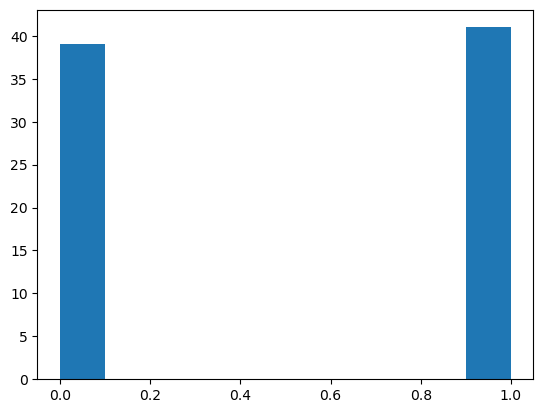

In [383]:
model_results(resnet_model,test_data)

In [2]:
# setting up paths
train_path = 'data/train/'
test_path = 'data/test/'
valid_path = 'data/valid/'

## Checking Images

In [3]:
im_1 = plt.imread(train_path + 'normal_train/normal037_132.png')

In [4]:
# checking shape
im_1.shape

(512, 512)

In [5]:
# checking dimensions
np.amax(im_1), np.amin(im_1)

(1.0, 0.0)

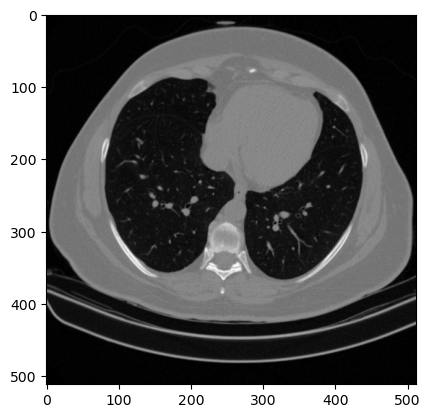

In [6]:
# A normal CT scan of the lung
plt.imshow(im_1,cmap='Greys_r');

In [7]:
im_2 = plt.imread(train_path + 'cancer_train/ad3.png')

In [8]:
im_2.shape

(192, 263, 3)

In [9]:
np.amax(im_2),np.amin(im_2)

(1.0, 0.0)

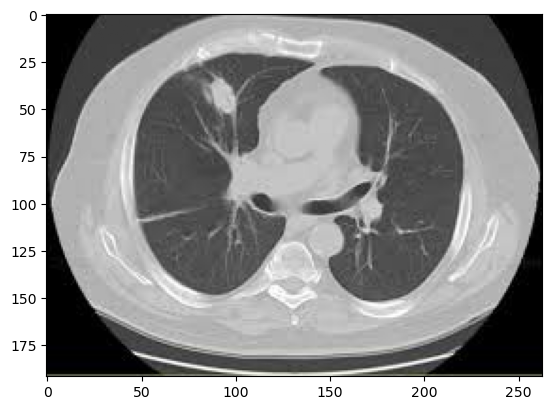

In [10]:
# Cancerous lung, CT Scan
plt.imshow(im_2);

## EDA
- After an initial clean and quick review of the data I ran several models to see how they would perform. Upon performance review, I discovered severe overfitting from my data. After performing a misclassification analysis, I discovered that many images were duplicates despite having different file names. Additionally, I discovered I had missed several misplaced images upon my first sweep of the data. After gathering more data, reviewing every image re-labeling my data, I ended with 2000 training images, 400 validation images and 80 testing images, split 50/50 respectively.

## Pre-Processing

In [35]:
# scaling data
train_gen = ImageDataGenerator(
    rescale=None, # no need to rescale as images are already scaled 0-1
    rotation_range=40, # range for random rotations
    width_shift_range=.1, # at random will shift width
    height_shift_range=.1, # at random will shift height
    zoom_range=.1, # range for random zooms
    horizontal_flip=False, # randomly flip horizontally
    vertical_flip=False # randomly flip vertically
    ) 

test_gen = ImageDataGenerator(rescale=None)


valid_gen = ImageDataGenerator(rescale=None)

In [362]:
# will use binary and grayscale for all images
train_data = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    color_mode='grayscale') 

valid_data = valid_gen.flow_from_directory(
    valid_path,
    class_mode='binary',
    color_mode='grayscale')
    
test_data = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False)# setting to False to get accurate test scores

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


## Checking Image Shape

In [29]:
train_data.image_shape

(256, 256, 1)

In [30]:
valid_data.image_shape

(256, 256, 1)

In [31]:
test_data.image_shape

(256, 256, 1)

## Examining Distribution of Data and Establishing Baseline

In [16]:
train_data.class_indices

{'cancer_train': 0, 'normal_train': 1}

In [17]:
train_unique, train_base = np.unique(train_data.classes,return_counts=True)
valid_unique, valid_base = np.unique(valid_data.classes,return_counts=True)
test_unique, test_base = np.unique(test_data.classes,return_counts=True)

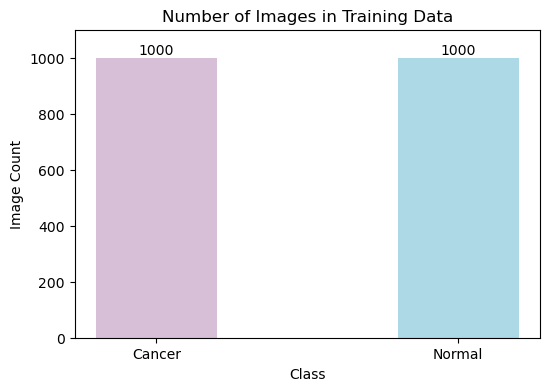

In [18]:
fig, ax = plt.subplots(figsize=(6,4))

ax.bar(x=['Cancer','Normal'],height=train_base,
       width=.4,color=['thistle','lightblue'])

plt.title('Number of Images in Training Data')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.ylim(top=1100)
plt.bar_label(ax.containers[0]);

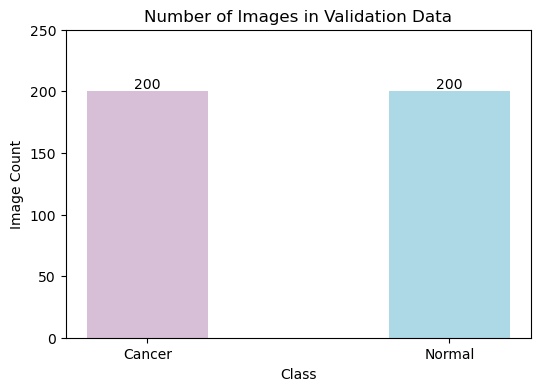

In [19]:
fig, ax = plt.subplots(figsize=(6,4))

ax.bar(x=['Cancer','Normal'],height=valid_base,
       width=.4,color=['thistle','lightblue'])

plt.title('Number of Images in Validation Data')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.ylim(top=250)
plt.bar_label(ax.containers[0]);

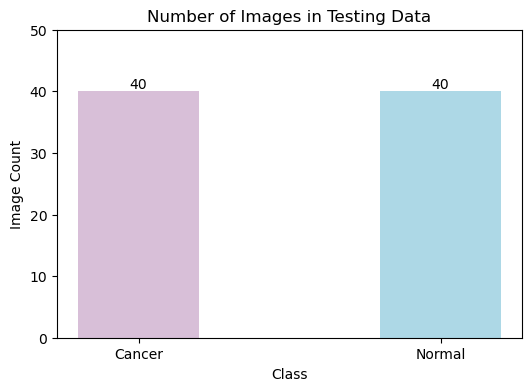

In [20]:
fig, ax = plt.subplots(figsize=(6,4))

ax.bar(x=['Cancer','Normal'],height=test_base,
       width=.4,color=['thistle','lightblue']);

plt.title('Number of Images in Testing Data')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.ylim(top=50)
plt.bar_label(ax.containers[0]);

Remember:

val_loss starts increasing, val_acc starts decreasing. This means model is cramming values not learning

val_loss starts increasing, val_acc also increases. This could be case of overfitting

More hidden units/layers = overfitting

If the loss decreases and the training accuracy also decreases, then you have some problem in your system, probably in your loss definition (maybe a too high regularization term ?) or maybe in your accuracy measurement.

If the loss decreases and the training accuracy increases but the validation accuracy decreases, you are overfitting.

A smaller learning rate will increase the risk of overfitting

## Modeling

## Model 4

In [37]:
# instantiating model
model4 = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Conv2D(input_shape=(256,256,1),padding='same',filters=16,kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(2,padding='same'),
    
    # Dense Layer
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.MaxPool2D(2,padding='same'),
    
    # Output
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')
])

In [38]:
opt = keras.optimizers.Adam(learning_rate=0.01)  # .001 is default

model4.compile(loss='binary_crossentropy', 
               optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0.03,
    verbose=1, 
    patience=6) 

In [ ]:
checkpoint_filepath = 'model_checkpoints/model4/'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
# model.load_weights(checkpoint_filepath)

In [86]:
history4 = model4.fit(
    train_data,
    batch_size=16,
    validation_data=valid_data,
    epochs=10,
    callbacks=[early_stop,cp_callback])

Epoch 1/10
63/63 [==============================] - 115s 2s/step - loss: 0.1937 - accuracy: 0.9225 - val_loss: 0.4727 - val_accuracy: 0.7975
Epoch 2/10
63/63 [==============================] - 127s 2s/step - loss: 0.1882 - accuracy: 0.9275 - val_loss: 0.4196 - val_accuracy: 0.8300
Epoch 3/10
63/63 [==============================] - 136s 2s/step - loss: 0.1838 - accuracy: 0.9320 - val_loss: 0.3291 - val_accuracy: 0.8950
Epoch 4/10
63/63 [==============================] - 109s 2s/step - loss: 0.1872 - accuracy: 0.9350 - val_loss: 0.2658 - val_accuracy: 0.9150
Epoch 5/10
63/63 [==============================] - 111s 2s/step - loss: 0.1847 - accuracy: 0.9305 - val_loss: 0.2324 - val_accuracy: 0.9125
Epoch 6/10
63/63 [==============================] - 107s 2s/step - loss: 0.1633 - accuracy: 0.9400 - val_loss: 0.2989 - val_accuracy: 0.8600
Epoch 7/10
63/63 [==============================] - 124s 2s/step - loss: 0.1995 - accuracy: 0.9230 - val_loss: 0.2831 - val_accuracy: 0.9175
Epoch 8/10
63

In [262]:
model4.save("models/model_4.0")

INFO:tensorflow:Assets written to: models/model_4.0/assets


INFO:tensorflow:Assets written to: models/model_4.0/assets


Epoch 10:

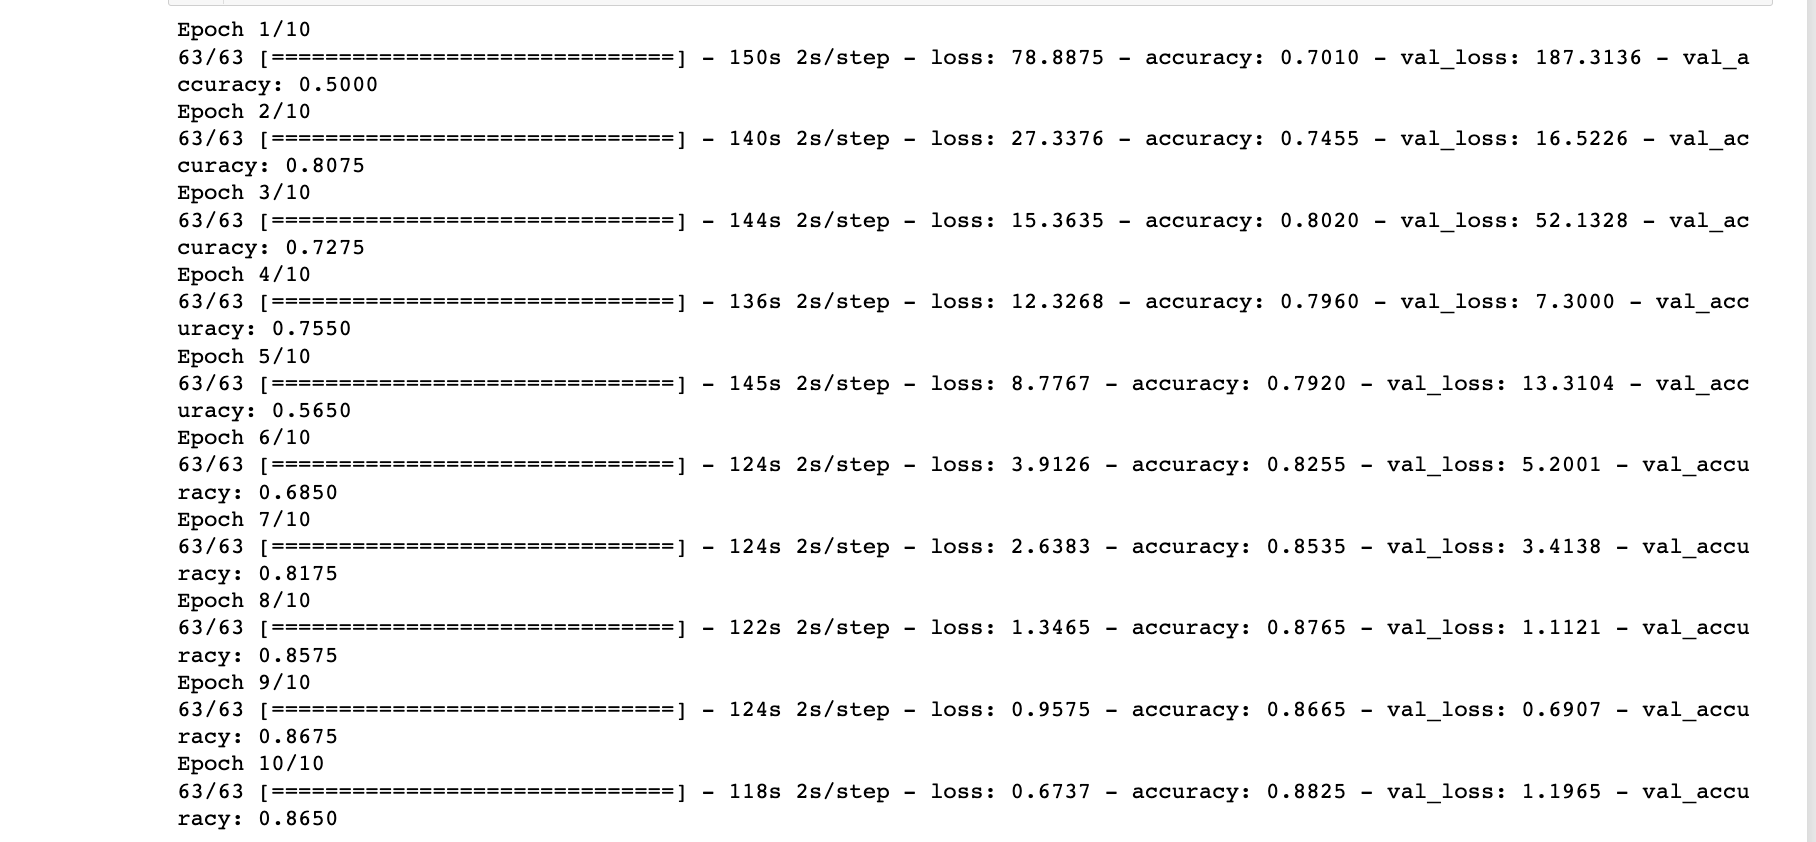

Epoch 28:
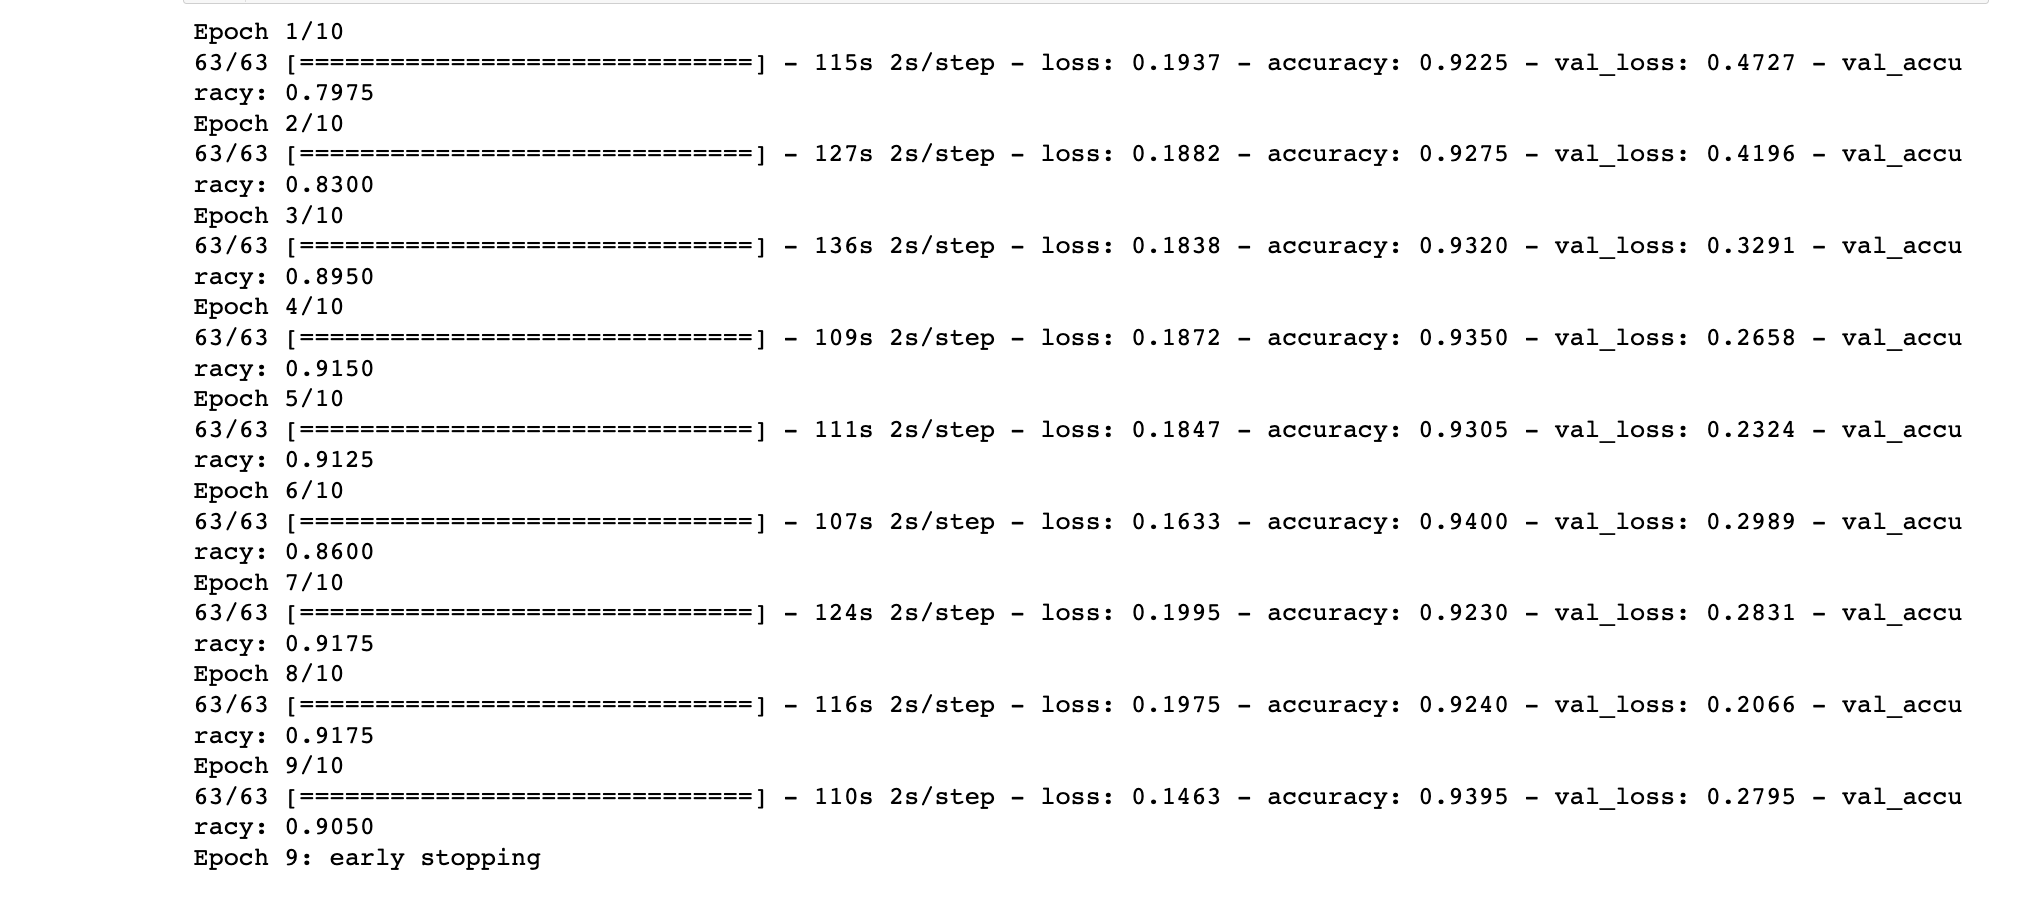

## Model 11

In [22]:
model11 = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Conv2D(input_shape=(256,256,1),padding='same',filters=16,kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(2,padding='same'),
    
    # Dense Layer
    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.MaxPool2D(2,padding='same'),
    
    # Output
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')
])

model11.compile(loss='binary_crossentropy', 
               optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.05,
    verbose=1, 
    patience=5)

In [214]:
checkpoint_filepath = 'model_checkpoints/model11/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
# model.load_weights(checkpoint_filepath)

In [215]:
history11 = model11.fit(
    train_data,
    batch_size=32,
    validation_data=valid_data,
    epochs=5,
    callbacks=[early_stop,model_checkpoint_callback])

Epoch 1/5
63/63 [==============================] - 94s 1s/step - loss: 1.4813 - accuracy: 0.7955 - val_loss: 2.3252 - val_accuracy: 0.6450
Epoch 2/5
63/63 [==============================] - 86s 1s/step - loss: 0.8931 - accuracy: 0.8560 - val_loss: 1.3040 - val_accuracy: 0.7050
Epoch 3/5
63/63 [==============================] - 84s 1s/step - loss: 1.2144 - accuracy: 0.8240 - val_loss: 0.5967 - val_accuracy: 0.9050
Epoch 4/5
63/63 [==============================] - 85s 1s/step - loss: 1.3956 - accuracy: 0.8290 - val_loss: 0.8587 - val_accuracy: 0.8275
Epoch 5/5
63/63 [==============================] - 86s 1s/step - loss: 1.1521 - accuracy: 0.8505 - val_loss: 0.8036 - val_accuracy: 0.8225


In [197]:
# model11.save("'models/model11.h5")

### Model 11 Results
First 10 Epochs

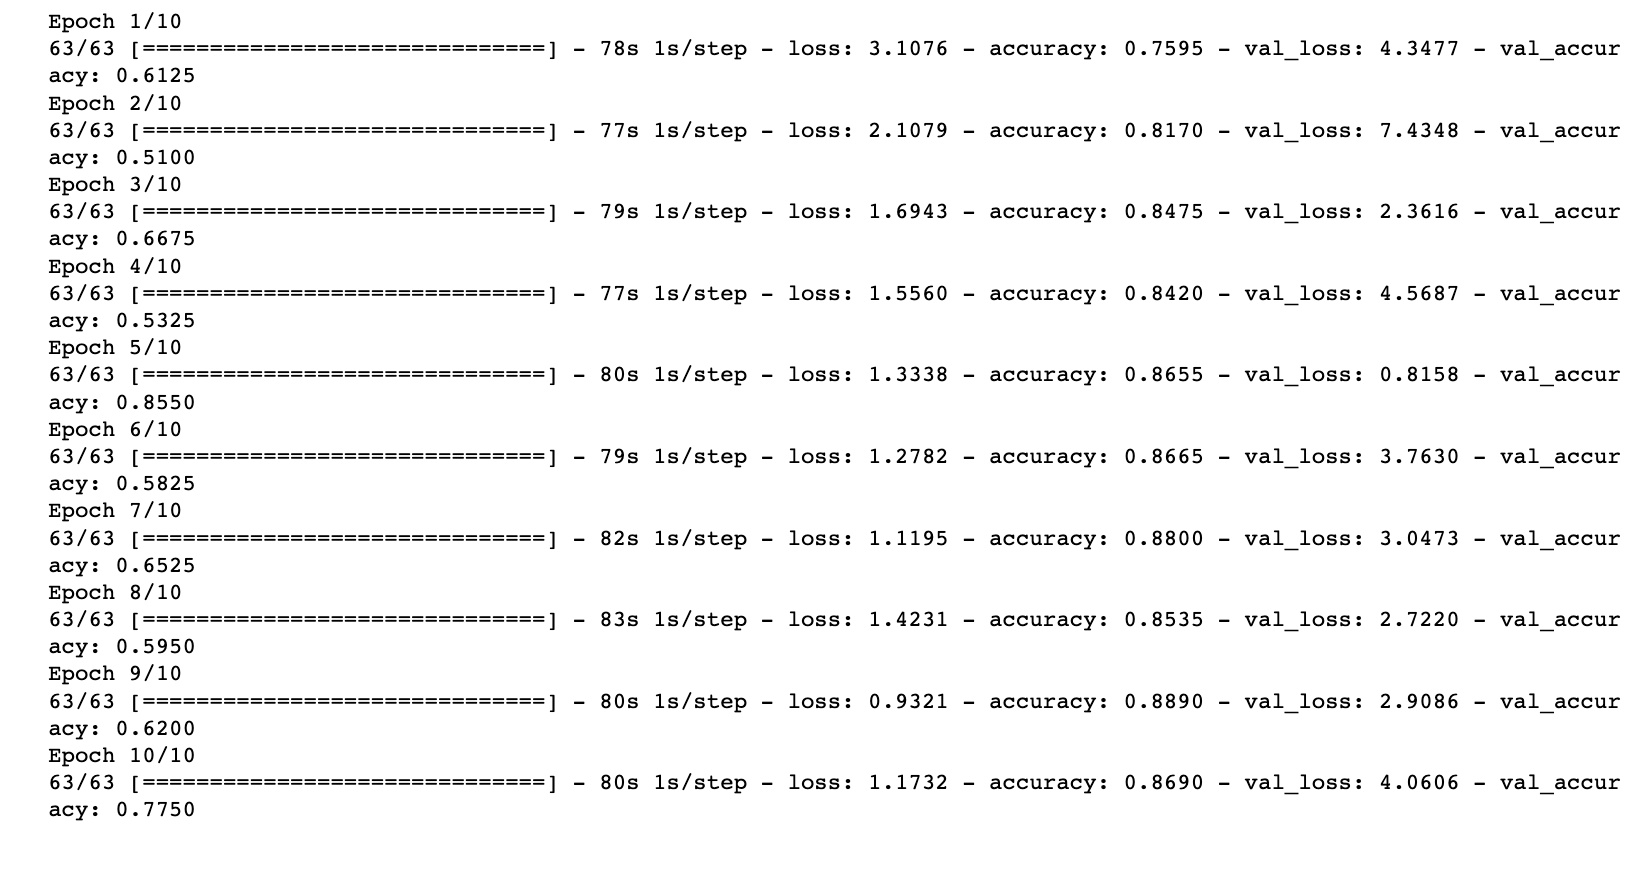

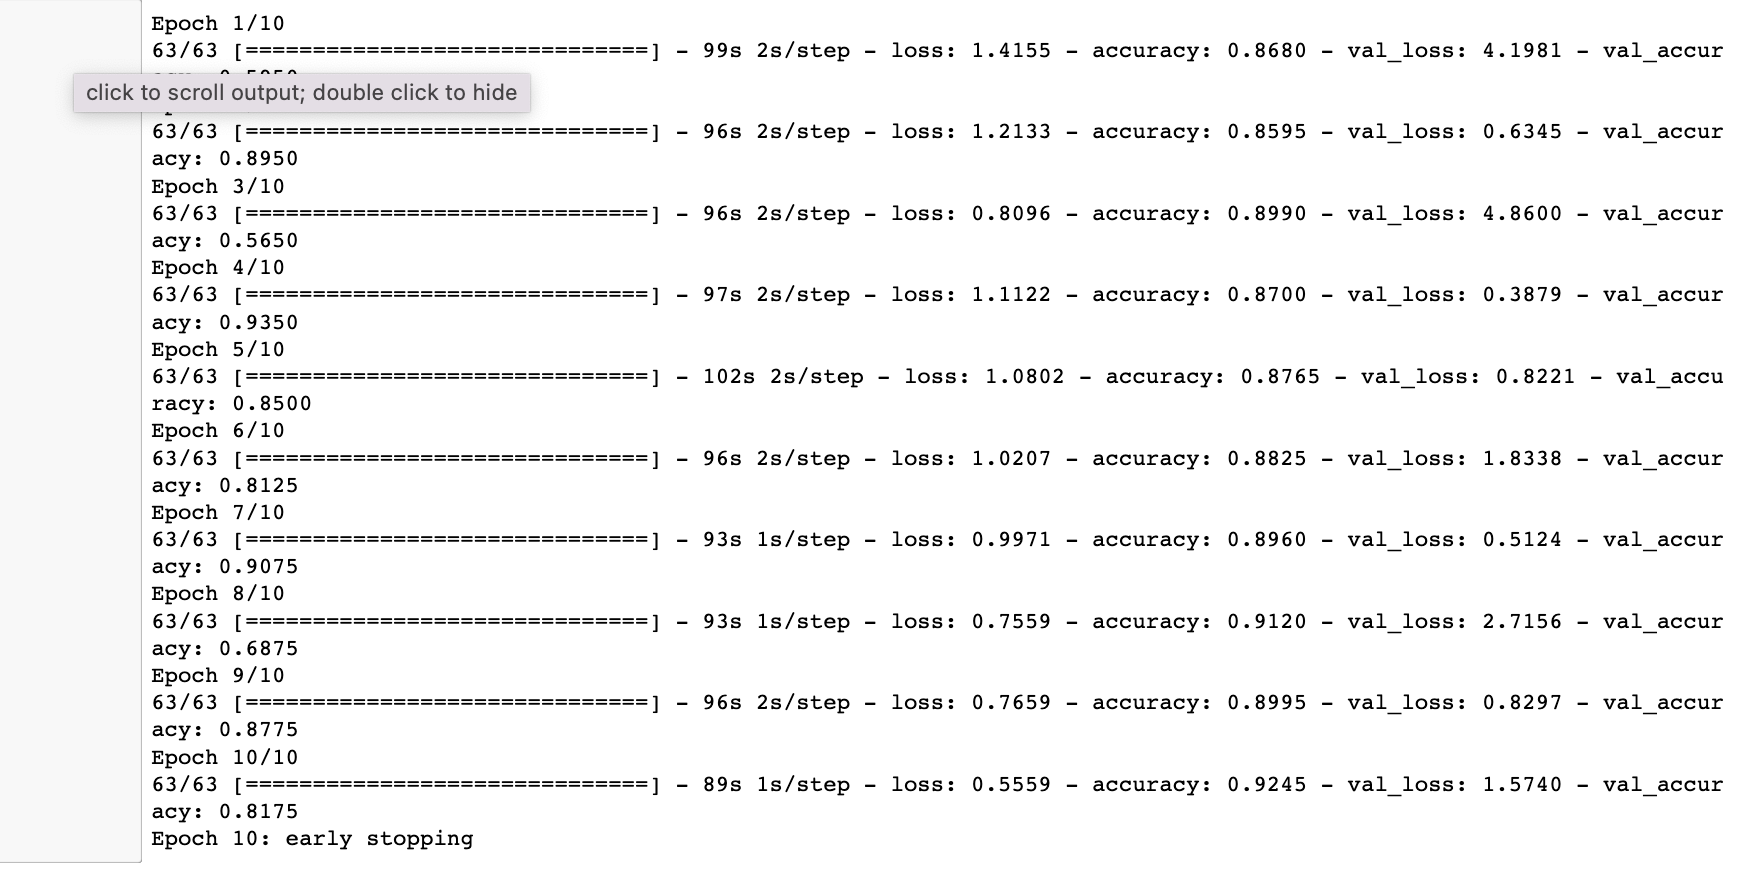

In [187]:
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Set figure size
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize = 25)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylabel('Categorical Crossentropy', fontsize = 18)
    plt.xticks(np.arange(10), np.arange(10))

    plt.legend(fontsize = 18);

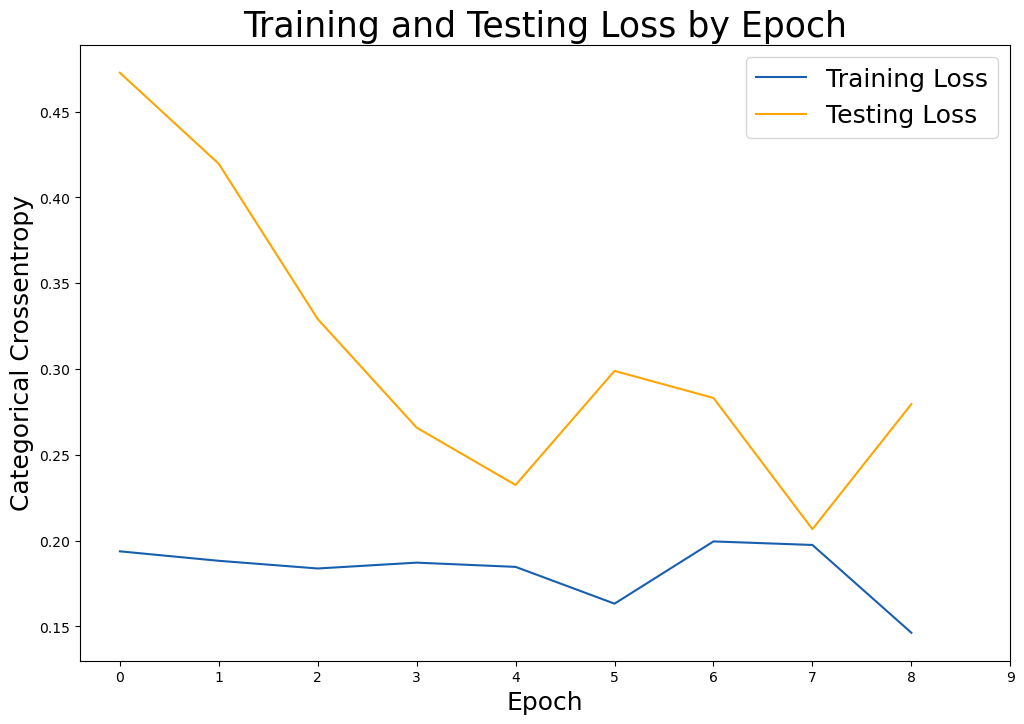

In [188]:
plot_loss(history4)

## Model 4 Predictions

In [355]:
# FOR PREDICTIONS SHUFFLE WILL BE FALSE
train_data = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False) 

valid_data = valid_gen.flow_from_directory(
    valid_path,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False)
    
test_data = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [253]:
# 0 cancer, 1 no cancer
# if they have cancer we do not want to miss it
# we care about minimizing false negatives aka increasing precision
# we want any misclassifications to be those without cancer classified as cancer, so a 1 in place of a 0
# we do not want cancer classfied as non cancer
# therefore we want the precision of 0 to be as high as possible

### Testing Data Misclassifications and Predictions

In [352]:
def model_results(model,data):
    y_pred = model.predict(data)
    predictions = []
    for each in y_pred:
        for num in each:
            if num <= .5:
                predictions.append(0)
            else:
                predictions.append(1)
    
    plt.hist(predictions)
    print(classification_report(data.classes,predictions))             
    return confusion_matrix(data.classes,predictions)  

3/3 [==============================] - 1s 347ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.97      0.93      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



array([[39,  1],
       [ 3, 37]])

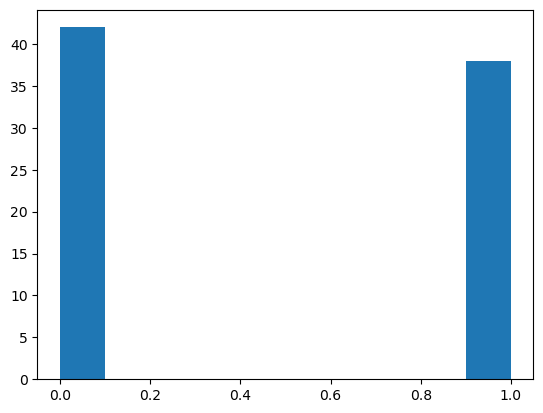

In [353]:
model_results(model4,test_data)

### Training Data Misclassification and Predictions

63/63 [==============================] - 33s 516ms/step
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1000
           1       0.97      0.80      0.88      1000

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



array([[979,  21],
       [203, 797]])

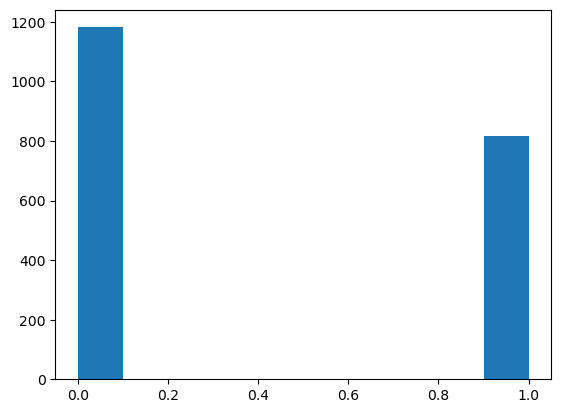

In [356]:
# 10/6/22 ; 28 epochs
model_results(model4,train_data)

### Valid Data Predictions and Misclassification

13/13 [==============================] - 5s 372ms/step
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       200
           1       0.98      0.83      0.90       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.90       400
weighted avg       0.91      0.91      0.90       400



array([[196,   4],
       [ 34, 166]])

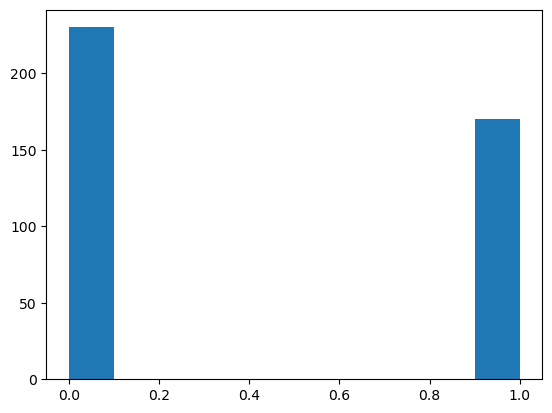

In [357]:
# 10/6/22 ; 28 epochs
model_results(model4,valid_data)

## End M4 Preds

## Model 11 Results:

### Testing Data Misclassifications and Predictions

3/3 [==============================] - 1s 287ms/step
              precision    recall  f1-score   support

           0       0.97      0.72      0.83        40
           1       0.78      0.97      0.87        40

    accuracy                           0.85        80
   macro avg       0.87      0.85      0.85        80
weighted avg       0.87      0.85      0.85        80



array([[29, 11],
       [ 1, 39]])

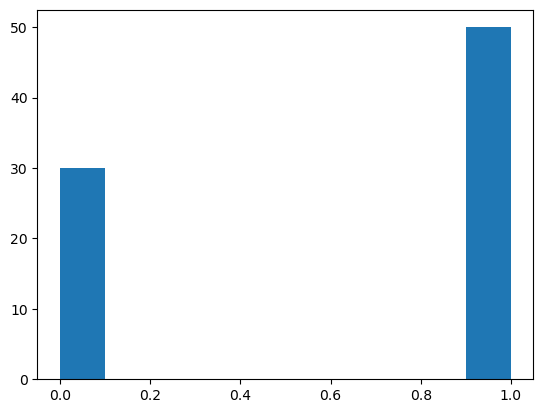

In [358]:
model_results(model11,test_data)

### Training Data Misclassifications and Predictions

63/63 [==============================] - 32s 502ms/step
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1000
           1       0.82      0.97      0.89      1000

    accuracy                           0.88      2000
   macro avg       0.89      0.88      0.87      2000
weighted avg       0.89      0.88      0.87      2000



array([[783, 217],
       [ 32, 968]])

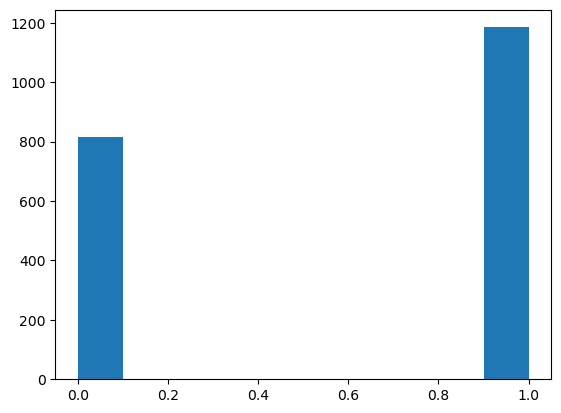

In [359]:
model_results(model11,train_data)

### Validation Data Misclassifications and Predictions

13/13 [==============================] - 6s 469ms/step
              precision    recall  f1-score   support

           0       0.96      0.67      0.79       200
           1       0.75      0.97      0.85       200

    accuracy                           0.82       400
   macro avg       0.86      0.82      0.82       400
weighted avg       0.86      0.82      0.82       400



array([[134,  66],
       [  5, 195]])

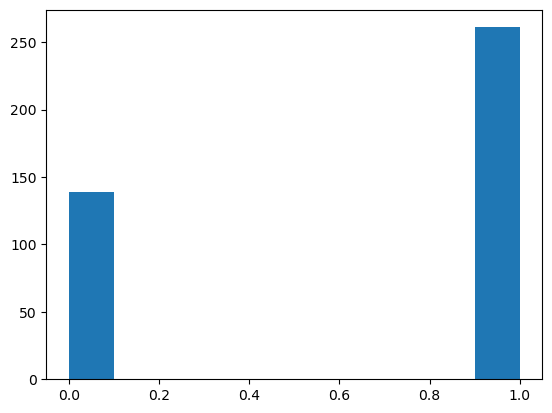

In [360]:
model_results(model11,valid_data)

## Transfer Learning

In [371]:
from tensorflow.keras.applications import ResNet50
from keras.models import Model

In [378]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(256,256,1))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # multi output
    output = Dense(1,activation = 'sigmoid')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [380]:
res_model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint_filepath = 'model_checkpoints/ResNet50_Model.hdf5/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_best_only=True)

res_history = res_model.fit(
train_data,
batch_size=32,
validation_data=valid_data,
epochs=10,
callbacks=[annealer,model_checkpoint_callback])

## Testing

## Model 11 Model.Save Method

In [199]:
preds_11 = model11.predict(test_data)

3/3 [==============================] - 2s 477ms/step


In [200]:
preds_m11 = []
for each in preds_11:
    for num in each:
        if num <= .5:
            preds_m11.append(0)
        else:
            preds_m11.append(1)

print(preds_m11[:10])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


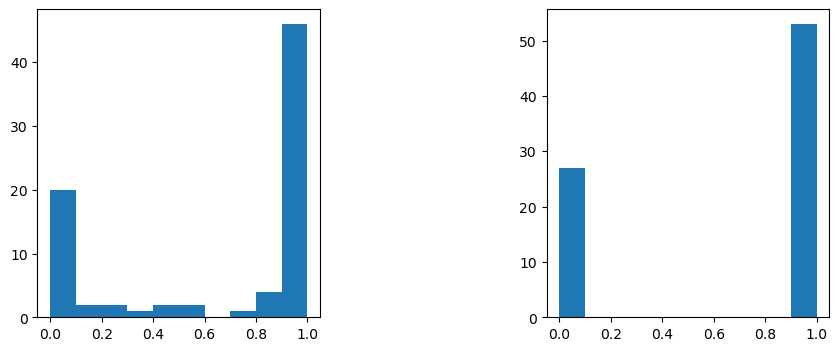

In [201]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].hist(preds_11)
ax[1].hist(preds_m11)
plt.subplots_adjust(left=0.01,
                    right=1.0,
                    wspace=0.8)

In [202]:
cm_11 = confusion_matrix(test_data.classes,preds_m11)
cm_11

array([[26, 14],
       [ 1, 39]])

In [203]:
print(classification_report(test_data.classes,preds_m11))

              precision    recall  f1-score   support

           0       0.96      0.65      0.78        40
           1       0.74      0.97      0.84        40

    accuracy                           0.81        80
   macro avg       0.85      0.81      0.81        80
weighted avg       0.85      0.81      0.81        80



In [205]:
from tensorflow.keras.models import load_model

In [206]:
test_model = load_model('model11.h5')

In [208]:
test_preds = test_model.predict(test_data)

3/3 [==============================] - 1s 340ms/step


In [209]:
test_preds_m11 = []
for each in test_preds:
    for num in each:
        if num <= .5:
            test_preds_m11.append(0)
        else:
            test_preds_m11.append(1)

print(test_preds_m11[:10])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


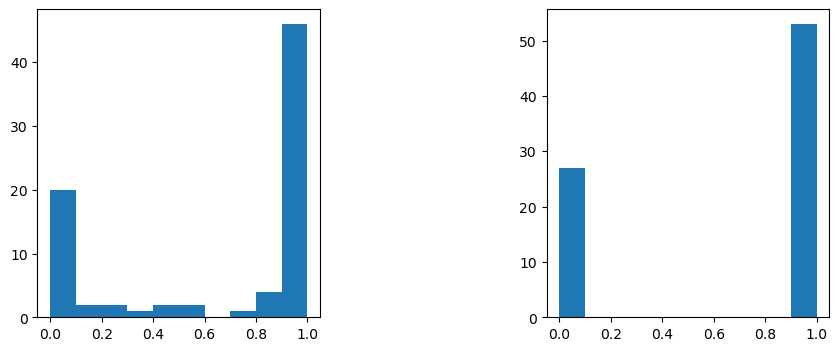

In [210]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].hist(test_preds)
ax[1].hist(test_preds_m11)
plt.subplots_adjust(left=0.01,
                    right=1.0,
                    wspace=0.8)

In [211]:
test_cm = confusion_matrix(test_data.classes,test_preds_m11)
test_cm

array([[26, 14],
       [ 1, 39]])

In [212]:
print(classification_report(test_data.classes,test_preds_m11))

              precision    recall  f1-score   support

           0       0.96      0.65      0.78        40
           1       0.74      0.97      0.84        40

    accuracy                           0.81        80
   macro avg       0.85      0.81      0.81        80
weighted avg       0.85      0.81      0.81        80



## Model 11, Model Checkpoint Callback method

In [216]:
preds_112 = model11.predict(test_data)

3/3 [==============================] - 1s 302ms/step


In [217]:
preds_m112 = []
for each in preds_112:
    for num in each:
        if num <= .5:
            preds_m112.append(0)
        else:
            preds_m112.append(1)

print(preds_m112[:10])

[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


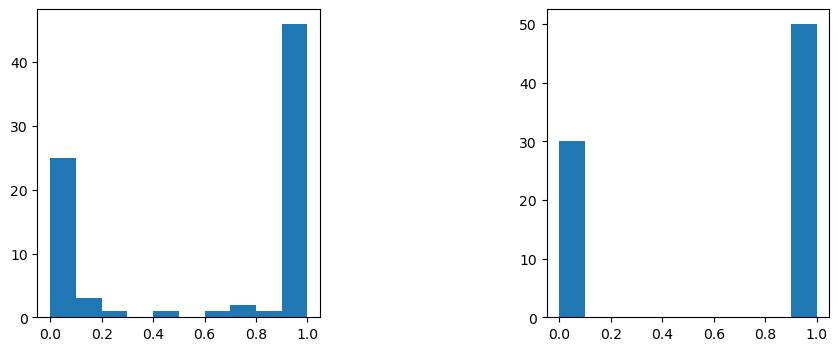

In [218]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].hist(preds_112)
ax[1].hist(preds_m112)
plt.subplots_adjust(left=0.01,
                    right=1.0,
                    wspace=0.8)

In [219]:
cm_112 = confusion_matrix(test_data.classes,preds_m112)
cm_112

array([[29, 11],
       [ 1, 39]])

In [220]:
print(classification_report(test_data.classes,preds_m112))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83        40
           1       0.78      0.97      0.87        40

    accuracy                           0.85        80
   macro avg       0.87      0.85      0.85        80
weighted avg       0.87      0.85      0.85        80



In [229]:
test_model2 = load_model('model11.h5')
test_model2.load_weights(checkpoint_filepath)

In [230]:
test_preds2 = test_model2.predict(test_data)

3/3 [==============================] - 1s 348ms/step


In [231]:
test_preds_m112 = []
for each in test_preds2:
    for num in each:
        if num <= .5:
            test_preds_m112.append(0)
        else:
            test_preds_m112.append(1)

print(test_preds_m112[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


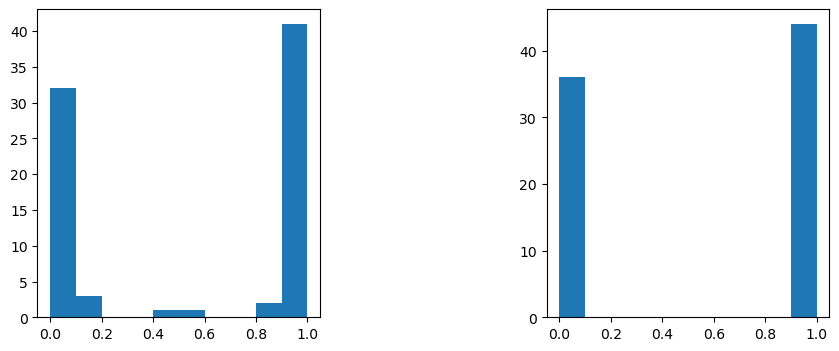

In [232]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].hist(test_preds2)
ax[1].hist(test_preds_m112)
plt.subplots_adjust(left=0.01,
                    right=1.0,
                    wspace=0.8)

In [233]:
test_cm2 = confusion_matrix(test_data.classes,test_preds_m112)
test_cm2

array([[33,  7],
       [ 3, 37]])

In [234]:
print(classification_report(test_data.classes,test_preds_m112))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87        40
           1       0.84      0.93      0.88        40

    accuracy                           0.88        80
   macro avg       0.88      0.88      0.87        80
weighted avg       0.88      0.88      0.87        80



In [240]:
print('Model 11 which was saved with save_model(model11.h5):')
print(classification_report(test_data.classes,preds_m11))
print('load_model(model11.h5):')
print(classification_report(test_data.classes,test_preds_m11))
print('Model 11, 5 epochs past previous model. This model had checkpoint callback')
print(classification_report(test_data.classes,preds_m112))
print('load_model(modell1.h5) and .load_weights(checkpoint_filepath)')
print(classification_report(test_data.classes,test_preds_m112))

Model 11 which was saved with save_model(model11.h5):
              precision    recall  f1-score   support

           0       0.96      0.65      0.78        40
           1       0.74      0.97      0.84        40

    accuracy                           0.81        80
   macro avg       0.85      0.81      0.81        80
weighted avg       0.85      0.81      0.81        80

load_model(model11.h5):
              precision    recall  f1-score   support

           0       0.96      0.65      0.78        40
           1       0.74      0.97      0.84        40

    accuracy                           0.81        80
   macro avg       0.85      0.81      0.81        80
weighted avg       0.85      0.81      0.81        80

Model 11, 5 epochs past previous model. This model had checkpoint callback
              precision    recall  f1-score   support

           0       0.97      0.72      0.83        40
           1       0.78      0.97      0.87        40

    accuracy                 

In [ ]:
# rescale and resize

In [ ]:
tf.keras.preprocessing.image.smart_resize(x, size, interpolation='bilinear'

In [258]:
# model.predict('data/test/cancer_test/000108 (2).png')

In [27]:
# instantiating model
model = Sequential()

# Convulutional Input Layer
model.add(Conv2D(
    input_shape=(256,256,1), # Input Shape set to match image shape 256,256,1
    filters=32, # filters at 32, should be fine to not overfit
    kernel_size=(3,3), # 3x3x1 for grayscale images 
    activation='relu', 
    padding='same')) # same spatial dimensions as inputs padding evenly left to right

# downsampling input along spatial dimensions
model.add(MaxPool2D(
      pool_size=(2,2)))

# hidden layer with dropout of 20 percent and l2 regularizer of 5%
model.add(Dense(128, 
                activation='relu',
                kernel_regularizer=l2(0.05)))
model.add(Dropout(.20))

# make the multidimensional input one-dimensional
model.add(Flatten())

# binary output layer
model.add(Dense(1,
    activation='sigmoid'))

In [28]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy', # monitoring validation accuracy
    min_delta=0.03, # want to see 3% change in performance
    verbose=1, # display callback message
    patience=6) # setting to 6 epochs due to consistent flucuation 
                # and strong performance in late epochs

In [29]:
history = model.fit(
    train_data,
    batch_size=32,
    validation_data=valid_data,
    epochs=10,
    callbacks=[early_stop])

Epoch 1/10
63/63 [==============================] - 141s 2s/step - loss: 209.1706 - accuracy: 0.6470 - val_loss: 36.3418 - val_accuracy: 0.7300
Epoch 2/10
63/63 [==============================] - 130s 2s/step - loss: 13.0618 - accuracy: 0.8145 - val_loss: 8.5381 - val_accuracy: 0.7350
Epoch 3/10
63/63 [==============================] - 141s 2s/step - loss: 6.8051 - accuracy: 0.8365 - val_loss: 16.5795 - val_accuracy: 0.5900
Epoch 4/10
63/63 [==============================] - 155s 2s/step - loss: 4.8125 - accuracy: 0.8645 - val_loss: 11.3727 - val_accuracy: 0.5775
Epoch 5/10
63/63 [==============================] - 157s 2s/step - loss: 3.6677 - accuracy: 0.8760 - val_loss: 6.2905 - val_accuracy: 0.6900
Epoch 6/10
63/63 [==============================] - 165s 3s/step - loss: 3.2099 - accuracy: 0.8695 - val_loss: 7.5065 - val_accuracy: 0.5825
Epoch 7/10
63/63 [==============================] - 138s 2s/step - loss: 2.5093 - accuracy: 0.8935 - val_loss: 4.1916 - val_accuracy: 0.6950
Epoch 7

### Model 1 Results:
- Pro: loss function consistently dropping w/accuracy consistently rising
- Con: Val_loss all over the place, val_accuracy stagnant
    

Model 1 was overfit/loss definition likely errored. Measures to counter: 
- added BatchNorms after each layer 
- an additional dense layer with fewer neurons w/similar penalties
- harsher l2 penalties 
- harsher dropouts

## Model 2

In [24]:
# instantiating model
model2 = Sequential()

# Convulutional Input Layer
model2.add(Conv2D(
    input_shape=(256,256,1),
    filters=32, # keeping filters at 32 
    kernel_size=(3,3), 
    activation='relu', 
    padding='same')) 

# maintaining mean and std output close to 0 and 1
model2.add(BatchNormalization())

model2.add(MaxPool2D(
      pool_size=(2,2)))

# hidden layer with dropout of 20 percent and l2 regularizer of 5%
model2.add(Dense(128, 
                activation='relu',
                kernel_regularizer=l2(0.05)))
model2.add(Dropout(.20))

# adding Conv2D layer
model2.add(Conv2D(
filters=16, # reducing filters to 16 to counter overfitting
kernel_size=(3,3),
activation='relu',
padding='same'))

model2.add(BatchNormalization())

# hidden layer with dropout of 10 percent and l2 regularizer of 1%
model2.add(Dense(32, 
                activation='relu',
                kernel_regularizer=l2(0.01)))

# batch norm
model2.add(BatchNormalization())

model2.add(Dropout(.15))

# downsampling input along spatial dimensions
model2.add(MaxPool2D
          (pool_size=(2, 2)))

# make the multidimensional input one-dimensional
model2.add(Flatten())

# binary output layer
model2.add(Dense(1,
    activation='sigmoid'))

In [25]:
model2.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy', # monitoring validation accuracy
    min_delta=0.03, # want to see 3% change in performance
    verbose=1, # display callback message
    patience=6) # setting to 6 epochs due to consistent flucuation 
                # and strong performance in late epochs

In [26]:
history2 = model2.fit(
    train_data,
    batch_size=32,
    validation_data=valid_data,
    epochs=10,
    callbacks=[early_stop])

Epoch 1/10
63/63 [==============================] - 299s 5s/step - loss: 5.2506 - accuracy: 0.8020 - val_loss: 6.7274 - val_accuracy: 0.7650
Epoch 2/10
63/63 [==============================] - 290s 5s/step - loss: 3.6712 - accuracy: 0.8700 - val_loss: 4.3880 - val_accuracy: 0.6800
Epoch 3/10
63/63 [==============================] - 345s 5s/step - loss: 3.3636 - accuracy: 0.8660 - val_loss: 3.5759 - val_accuracy: 0.7700
Epoch 4/10
63/63 [==============================] - 327s 5s/step - loss: 2.7538 - accuracy: 0.8885 - val_loss: 2.1293 - val_accuracy: 0.8950
Epoch 5/10
63/63 [==============================] - 312s 5s/step - loss: 2.1838 - accuracy: 0.9060 - val_loss: 6.4769 - val_accuracy: 0.7725
Epoch 6/10
63/63 [==============================] - 316s 5s/step - loss: 1.6054 - accuracy: 0.9265 - val_loss: 4.1565 - val_accuracy: 0.7775
Epoch 7/10
63/63 [==============================] - 320s 5s/step - loss: 1.9264 - accuracy: 0.9055 - val_loss: 2.9225 - val_accuracy: 0.7975
Epoch 8/10
63

### Model 2 Results
Model 2 is better, still overfit, potential issue could be "complexity" of model. Val_loss jumped on the last epoch indicating overfiting, though may just need more time to run.

Model 3 will:
- reduce filters in input layer
- remove dense layer 
- drastically harsh l2 penalty
- harsher dropout
- learning rate from .001 to .01

## Model 3

In [27]:
# instantiating model
model3 = Sequential()

# Convulutional Input Layer
model3.add(Conv2D(
    input_shape=(256,256,1), # Input Shape 
    filters=16, # reducing filters to 16 to avoid overfitting
    kernel_size=(3,3), # 3x3x1 for grayscale images 
    activation='relu', 
    padding='same')) # same spatial dimensions as inputs padding evenly left to right

# adding batch norm 
model3.add(BatchNormalization())

# downsampling input along spatial dimensions
model3.add(MaxPool2D(
      pool_size=(2,2)))

# hidden layer with dropout of 30 percent and l2 regularizer of 10% to counter overfitting
model3.add(Dense(128, 
                activation='relu',
                kernel_regularizer=l2(0.1)))
model3.add(Dropout(.30))

# another batch norm
model3.add(BatchNormalization()) # wrong spot!

# make the multidimensional input one-dimensional
model3.add(Flatten())

# binary output layer
model3.add(Dense(1,
    activation='sigmoid'))

In [28]:
opt = keras.optimizers.Adam(learning_rate=0.01) # increasing learning rate to counter overfitting

model3.compile(loss='binary_crossentropy', 
              optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy', # monitoring validation accuracy
    min_delta=0.03, # want to see 3% change in performance
    verbose=1, # display callback message
    patience=6) # setting to 6 epochs due to consistent flucuation 
                # and strong performance in late epochs

In [29]:
history3 = model3.fit(
    train_data,
    batch_size=32,
    validation_data=valid_data,
    epochs=10,
    callbacks=[early_stop])

Epoch 1/10
63/63 [==============================] - 193s 3s/step - loss: 80.4135 - accuracy: 0.7865 - val_loss: 26.3385 - val_accuracy: 0.7650
Epoch 2/10
63/63 [==============================] - 183s 3s/step - loss: 42.0023 - accuracy: 0.8300 - val_loss: 265.1301 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 196s 3s/step - loss: 34.2801 - accuracy: 0.8390 - val_loss: 37.6865 - val_accuracy: 0.7525
Epoch 4/10
63/63 [==============================] - 200s 3s/step - loss: 19.5586 - accuracy: 0.8525 - val_loss: 16.3355 - val_accuracy: 0.8125
Epoch 5/10
63/63 [==============================] - 208s 3s/step - loss: 12.3095 - accuracy: 0.8665 - val_loss: 17.9018 - val_accuracy: 0.7225
Epoch 6/10
63/63 [==============================] - 210s 3s/step - loss: 7.5684 - accuracy: 0.8705 - val_loss: 7.7954 - val_accuracy: 0.7950
Epoch 7/10
63/63 [==============================] - 212s 3s/step - loss: 5.3574 - accuracy: 0.8625 - val_loss: 9.4122 - val_accuracy: 0.7825
Ep

### Model 3 Results
Model 3 loss consisently decreasing, accuracy is stagnant. Val loss and acc stagnant as well, learning rate maybe too high but first will try:
- will try conv > batch norm > activation > dropout > pool
- keeping only droput and not regularizer
- reduce dense neurons to 64
- reduce batch_size to 16
- increase/decresing learning rate?

## Model 12

In [93]:
model12 = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Conv2D(input_shape=(256,256,1),padding='same',filters=16,kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(2,padding='same'),
    
    # Dense Layer
    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.MaxPool2D(2,padding='same'),
    
    # Dense to Output
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')
])

opt = keras.optimizers.Adam(learning_rate = 0.003, 
                            beta_1 = 0.9, beta_2 = 0.999, # averaging over learned iterations
                            epsilon = 0.1, decay = 0.0)

model12.compile(loss='binary_crossentropy', 
                optimizer=opt, metrics=['accuracy'])

annealer = ReduceLROnPlateau(monitor = 'val_accuracy', # Reduce LR if val_acc is stagnant
                             factor = 0.70, # Rate the learning rate will decrease
                             patience = 5, # epochs to wait 
                             verbose = 1, # Notify
                             min_lr = 1e-4) # lower limit on LR

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min',
#     baseline=.03,
#     verbose=1, 
#     patience=3)

In [105]:
history12 = model12.fit(
    train_data,
    batch_size=32,
    validation_data=valid_data,
    epochs=20,
    callbacks=[annealer])

Epoch 1/20
63/63 [==============================] - 96s 2s/step - loss: 0.9091 - accuracy: 0.8110 - val_loss: 0.8775 - val_accuracy: 0.7900 - lr: 0.0021
Epoch 2/20
63/63 [==============================] - 92s 1s/step - loss: 0.8851 - accuracy: 0.8090 - val_loss: 0.6204 - val_accuracy: 0.8175 - lr: 0.0021
Epoch 3/20
63/63 [==============================] - 89s 1s/step - loss: 0.8264 - accuracy: 0.8140 - val_loss: 1.8964 - val_accuracy: 0.5825 - lr: 0.0021
Epoch 4/20
63/63 [==============================] - 91s 1s/step - loss: 1.0862 - accuracy: 0.7980 - val_loss: 0.3299 - val_accuracy: 0.9000 - lr: 0.0021
Epoch 5/20
63/63 [==============================] - 89s 1s/step - loss: 0.7021 - accuracy: 0.8145 - val_loss: 3.5437 - val_accuracy: 0.5125 - lr: 0.0021
Epoch 6/20
63/63 [==============================] - 88s 1s/step - loss: 0.5997 - accuracy: 0.8330 - val_loss: 0.7470 - val_accuracy: 0.7125 - lr: 0.0021
Epoch 7/20
63/63 [==============================] - 91s 1s/step - loss: 0.6750 - a

KeyboardInterrupt: 

First 10:
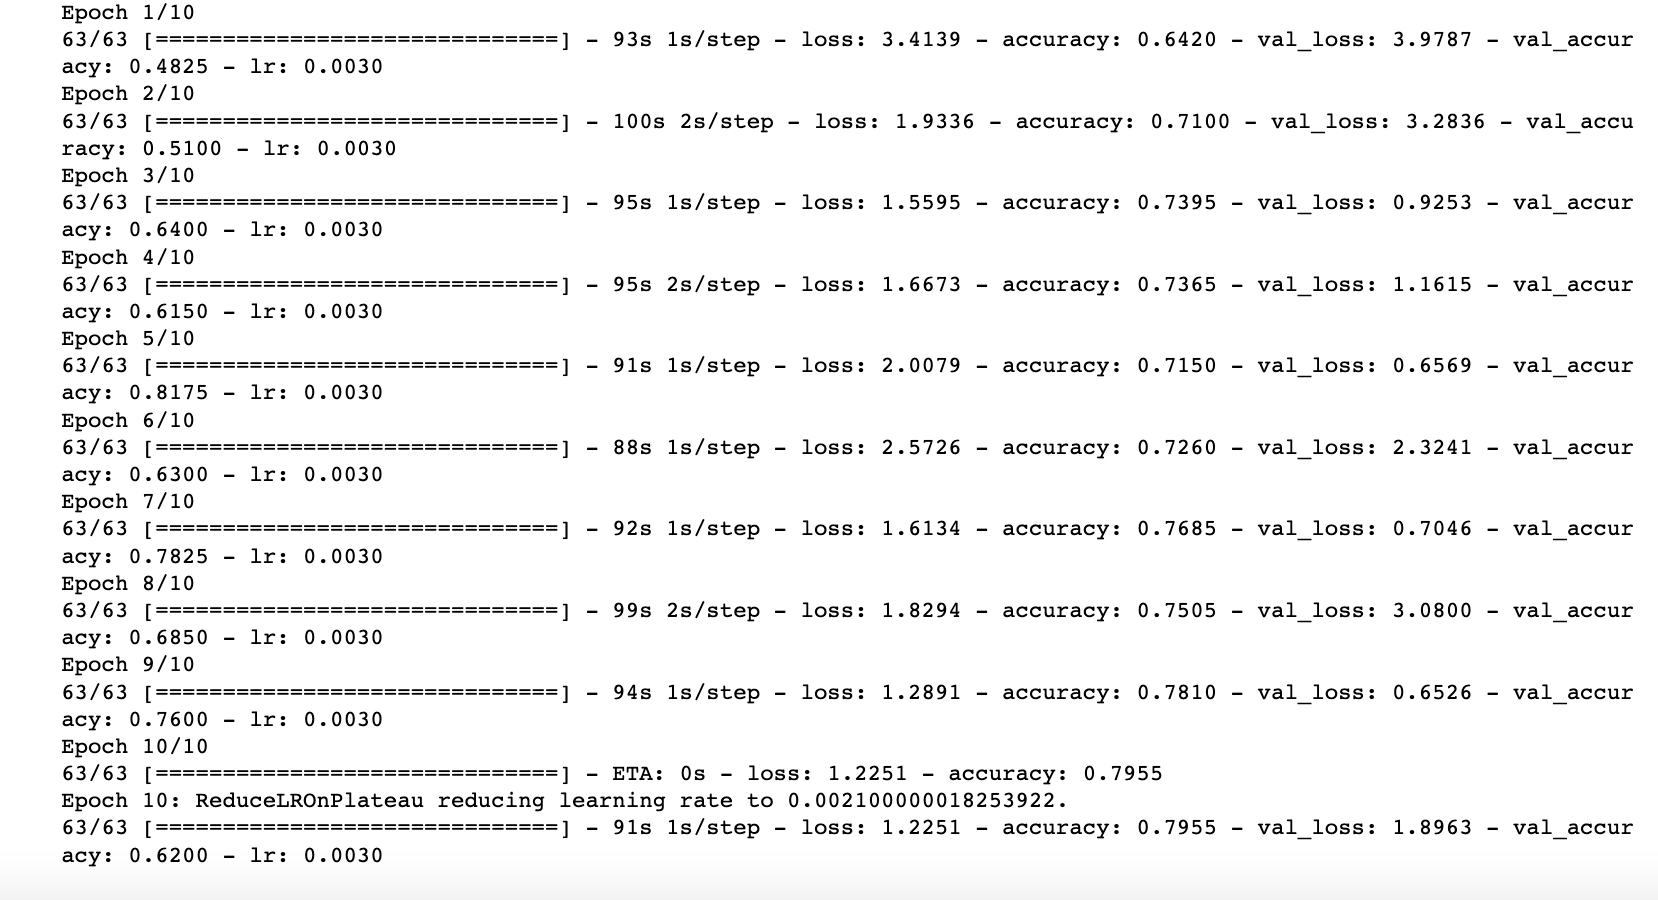

In [ ]:
      self.C1 = Conv2D(input_shape =input_shape,padding='same',filters=16,kernel_size=(3,3))
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPool2D(2, padding='same')
        
        self.D1 = Dense(64),
        self.B2 = BatchNormalization()
        self.A2 = Activation('relu')
        self.Dr1 = Dropout(0.3)
        self.P2 = MaxPool2D(2, padding='same')
        
        self.F1 = Flatten()
        self.D2 = Dense(1, activation='sigmoid')
        
        
    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)
        
        x = self.D1(x)
        x = self.B2(x)
        x = self.A2(x)
        x = self.Dr1(x)
        x = self.P2(x)
        
        x = self.F1(x)
        y = self.D2(x)
        
        return y
    
    def __repr__(self):
        name = 'Custom_Model_4.0'
        return name
    
    
cust = Custom_Model()